In [71]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
import glob

In [72]:
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [73]:
IMG_SIZE = (224, 224)

def load_image_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    
    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask>0, tf.float32)
    
    return image, mask

In [74]:
image_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/images'
mask_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/masks'

In [75]:
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))

In [76]:
train_img, temp_img, train_mask, temp_mask = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

In [77]:
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5, random_state=42)

In [78]:
def make_dataset(img_ds, mask_ds, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_ds, mask_ds))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [79]:
train_ds = make_dataset(train_img, train_mask)
val_ds = make_dataset(val_img, val_mask, shuffle=False)
test_ds = make_dataset(test_img, test_mask, shuffle=False)

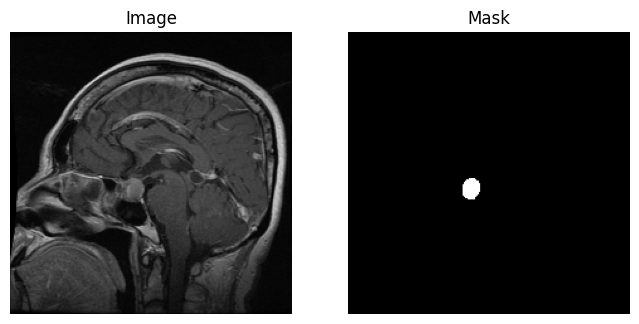

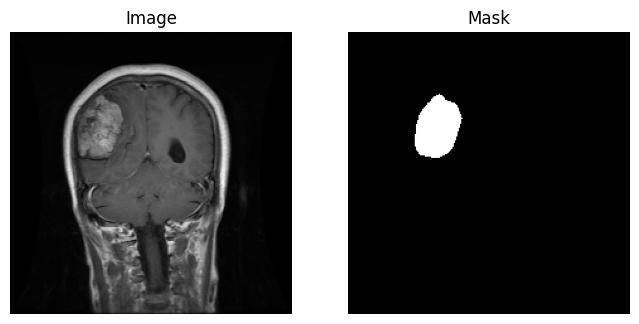

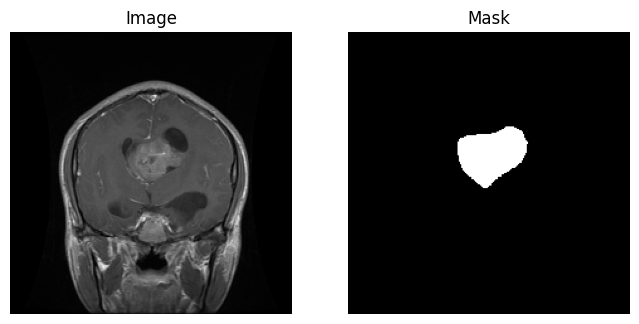

In [80]:
def visualize_batch(dataset, num=3):
    for images, masks in dataset.take(1):
        for i in range(num):
            plt.figure(figsize=(8,4))
            plt.subplot(1, 2, 1)
            plt.imshow(images[i])
            plt.title('Image')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title('Mask')
            plt.axis('off')
            plt.show()

visualize_batch(train_ds)

In [81]:
from models.mri_tumor_segmentation.u_net import unet_model

model = unet_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_57 (Conv2D)          (None, 224, 224, 64)         1792      ['input_4[0][0]']             
                                                                                                  
 conv2d_58 (Conv2D)          (None, 224, 224, 64)         36928     ['conv2d_57[0][0]']           
                                                                                                  
 max_pooling2d_12 (MaxPooli  (None, 112, 112, 64)         0         ['conv2d_58[0][0]']           
 ng2D)                                                                                      

In [82]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    return 1-(2.*intersection+smooth)/(tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)+smooth)

In [83]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce+d_loss

In [84]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

model.compile(optimizer=tf.keras.optimizers.legacy.Adam(1e-3),
              loss=combined_loss,
              metrics=['accuracy', dice_coef])


In [85]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=5,
    mode='max',
    restore_best_weights=True
)

TRAINING PERFORMED ON GOOGLE COLAB GPU

In [ ]:
model.evaluate(test_ds)